Plotting the anatomy at the group level

In [1]:
import os
import json

import numpy as np
import pandas as pd

from brainets.io import load_marsatlas

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_style("whitegrid")

# Global variables

In [17]:
# defines where files are located
root = '/envau/work/bagamore/brovelli.a/Data/Neurophy/SEEG_EBRAINS/Cohort %s/anat/%s/%s.csv'
subject = 'HID-Sub-000'

# load the cohort config file
with open("../../seeg-ebrains/config/db_cohort.json", 'r') as f:
    cfg = json.load(f)


# Load the default MarsAtlas table

In [18]:
ma = load_marsatlas().set_index(['LR_Name'])
ma

,Label,Hemisphere,Lobe,Name_FS,Name,Full name,BA,xcoord_2D,ycoord_2D,xcoord_3D,ycoord_3D,zcoord_3D
LR_Name,,,,,,,,,,,,
L_VCcm,1,L,Occipital,Medial Occipital,VCcm,Caudal Medial Visual Cortex,17/18,-13,11,-47,20,55
L_VCl,2,L,Occipital,Lateral Occipital,VCl,Lateral Visual Cortex,37/19/18,-23,16,-34,42,57
L_VCs,3,L,Occipital,Superior Occipital,VCs,Superior Visual Cortex,19/39,-16,19,-37,33,83
L_Cu,4,L,Occipital,Cuneus,Cu,Cuneus,18/19,-10,24,-44,11,78
L_VCrm,5,L,Occipital,Lingual,VCrm,Rostral Medial Visual Cortex,18/19,-8,17,-27,15,57
...,...,...,...,...,...,...,...,...,...,...,...,...
R_Put,251,R,Subcortical,Putamen,Put,Putamen,0,8,48,28,-24,48
R_GP,252,R,Subcortical,Pallidum,GP,Pallidum,0,5,43,25,-19,48
R_Hipp,253,R,Subcortical,Hippocampus,Hipp,Hippocampus,0,3,31,4,-23,41


# Load the anatomy

In [20]:
# define the list of important columns to keep
use_col = ['contact', 'MarsAtlas']
bad_parcel = 'not in a mars atlas parcel'

anat_gp, missing, bad_format = [], [], []
for coh in ['I', 'II', 'III']:
    suj_range = cfg[coh]['s_range']
    for suj in range(suj_range[0], suj_range[1] + 1):
        print(f"Cohort {coh} : {suj}", end='\r')
        # define subject name
        id_suj = str(suj)
        s_name = subject[0:-len(id_suj)] + id_suj
        
        # define where the file is located
        anat_path = root % (coh, s_name, s_name)
        
        if not os.path.isfile(anat_path):
            missing += [s_name]
            continue
        
        # load the anat
        df = pd.read_csv(anat_path, skiprows=2, sep='\t').loc[:, use_col]
        
        # skip duplicate contacts with "-" pattern
        contacts = list(df['contact'])
        is_bip = ['-' not in k for k in contacts]
        df = df.loc[is_bip, :]
        
        # drop bad parcels
        idx_bad = df['MarsAtlas'].str.match(bad_parcel)
        try:
            df = df.loc[~idx_bad, :]
        except:
            bad_format += [s_name]
            continue
        
        # get lobe
        df['Lobe'] = list(ma.loc[df['MarsAtlas'], :]['Lobe'])

        # get the hemisphere
        df['Hemisphere'] = [k[0] for k in df['MarsAtlas']]
        
        # drop 'L_' and 'R_'
        df.replace({'L\\_': '', 'R\\_': ''}, regex=True, inplace=True)
        
        # rename 'MarsAtlas' -> 'Name'
        df = df.rename(columns={'MarsAtlas': 'Name'})

        
        # add subject name to the columns
        df['subject'] = [s_name] * len(df)
        
        anat_gp += [df]

# concatenate anat of the group
anat_gp = pd.concat(anat_gp, axis=0).reset_index()

print(f'Missing subjects : {missing}')
print(f'Bad format : {bad_format}')

Missing subjects : ['HID-Sub-054']
Bad format : ['HID-Sub-030']


In [21]:
anat_gp

,index,contact,Name,Lobe,Hemisphere,subject
0,0,ep01,PCC,Parietal,L,HID-Sub-001
1,1,ep02,Sdm,Parietal,L,HID-Sub-001
2,5,ep06,Mdl,Frontal,L,HID-Sub-001
3,6,ep07,Mdl,Frontal,L,HID-Sub-001
4,7,ep08,Mdl,Frontal,L,HID-Sub-001
...,...,...,...,...,...,...
7926,99,X13,PCm,Parietal,R,HID-Sub-070
7927,100,X14,PCm,Parietal,R,HID-Sub-070
7928,101,X15,PCm,Parietal,R,HID-Sub-070
7929,102,X16,PCm,Parietal,R,HID-Sub-070


# Counting
## Count the number of sites per brain region

In [12]:
# count the number of sites per parcel
df_nb_sites = anat_gp.groupby(['Lobe', 'Hemisphere', 'Name']).count()['index']
# clean up columns
df_nb_sites = df_nb_sites.reset_index().rename(columns={'index': '# contacts'})
# change index method
df_nb_sites = df_nb_sites.set_index(['Lobe', 'Hemisphere'])

## Count the number of unique subjects per brain region

In [13]:
# start by removing the mutliple conctacts per subject in a single roi
anat_gp_u = anat_gp.loc[:, ['Name', 'Lobe', 'Hemisphere', 'subject']].drop_duplicates().reset_index()
# get the number of unique subject per brain region
df_nb_suj = anat_gp_u.groupby(['Lobe', 'Hemisphere', 'Name']).count()['index']
# clean up the columns
df_nb_suj = df_nb_suj.reset_index().rename(columns={'index': '# subjects'})
# change index method
df_nb_suj = df_nb_suj.set_index(['Lobe', 'Hemisphere'])

# Plotting
## Plotting MarsAtlas function

In [14]:
def ma_plot(df, x, fig_title='', color='blue'):
    max_sites = np.array(list(df[x])).max()
    fig = plt.figure(figsize=(20, 12))

    fig.suptitle(fig_title, fontsize=20, fontweight='bold', y=.82)

    gs = GridSpec(25, 23, left=0.07, bottom=0.08, right=0.98, top=0.8, wspace=.4)
    subplots = {
        'Frontal': {'L' : gs[0:19, 0:5], 'R' : gs[0:19, 18:23]},
        'Parietal': {'L' : gs[11:19, 6:11], 'R' : gs[11:19, 12:17]},
        'Occipital': {'L' : gs[20:25, 6:11], 'R' : gs[20:25, 12:17]},
        'Temporal': {'L' : gs[20:25, 0:5], 'R' : gs[20:25, 18:23]}
#         'Subcortical': {'L' : gs[5:10, 6:11], 'R' : gs[5:10, 12:17]},
        }
    im_gs = gs[0:5, 6:17]

    for lobe in subplots.keys():
        for hemi in ['L', 'R']:
            ax = plt.subplot(subplots[lobe][hemi])
            df_hl = df.loc[lobe].loc[hemi]
            sns.barplot(data=df_hl, x=x, y='Name', ax=ax, orient='h', color=color)
            plt.gca().invert_yaxis()
            plt.ylabel(''), plt.xlim(0., max_sites)
            plt.title(f"{lobe} ({hemi})", fontweight='bold', fontsize=15)
            if lobe not in ['Temporal', 'Occipital']:
                plt.tick_params(axis='x', which='both', bottom=False, top=False,
                                labelbottom=False)
                plt.xlabel('')
    
    img_data = plt.imread('ma.png')
    ax = fig.add_subplot(im_gs, position=[.27, .5, .48, .3])
    ax.imshow(img_data)
    ax.axis(False)
    
    return plt.gcf()


## Plot the number of sites per brain region

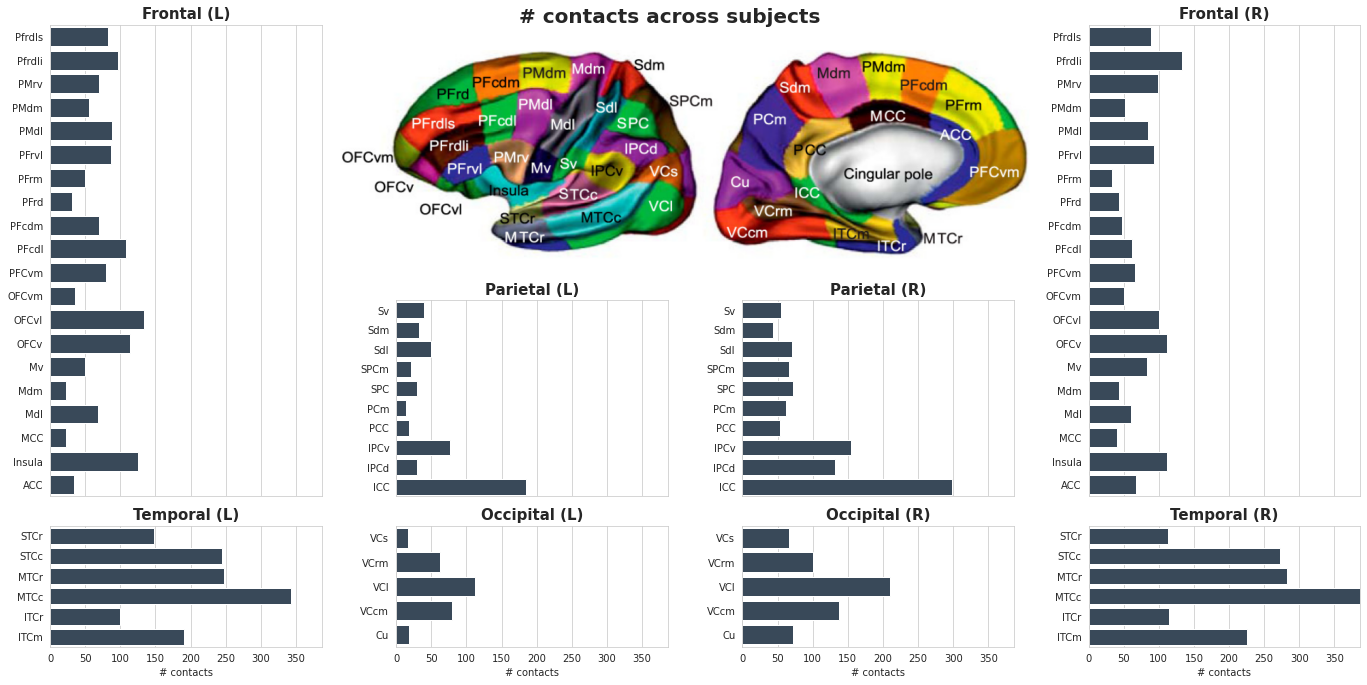

In [15]:
fig_c = ma_plot(df_nb_sites, '# contacts', fig_title='# contacts across subjects', color='#34495e')

## Plot the number of unique subject per brain region

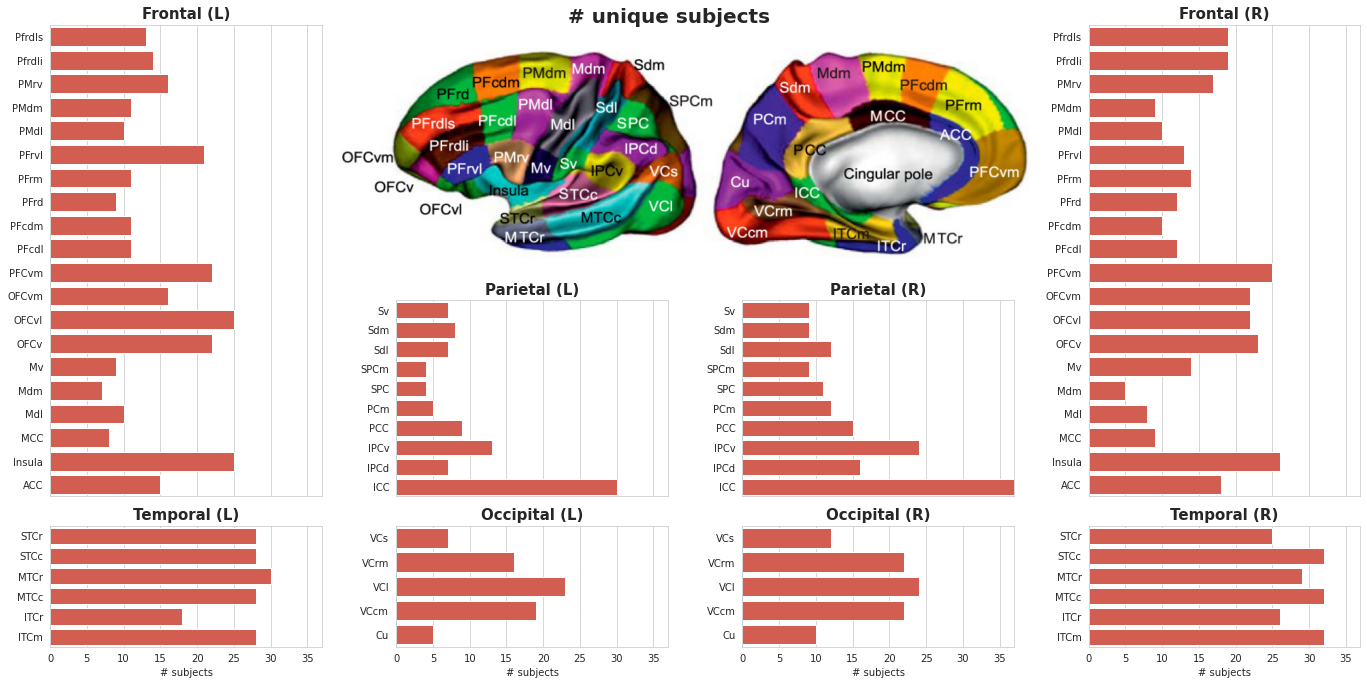

In [16]:
fig_s = ma_plot(df_nb_suj, '# subjects', fig_title='# unique subjects', color='#e74c3c')